## Load Data

In [2]:
import numpy as np

datasets = ['train', 
            'instrument_ADIR1995', 'instrument_ADIR2003', 
'instrument_ADOS_Module1', 'instrument_ADOS_Module2', 'instrument_ADOS_Module3', 'instrument_ADOS_Module4', 'instrument_ADOS2_Module_Toddler',
'instrument_SRS_Adult', 'instrument_SRS_Child', 
            'entry']

num_folds = 5

# grab m, n
m, n = np.load('../data/all_samples_ordinal_cv%d_%s.npy' % (0, 'train')).shape

# load data
actual_data_train = np.zeros((num_folds, m, n))
actual_data_test_instrument = np.zeros((num_folds, m, n))
actual_data_test_entry = np.zeros((num_folds, m, n))

for fold in range(0, num_folds):
    for i, d in enumerate(datasets):
        filename = '../data/all_samples_ordinal_cv%d_%s.npy' % (fold, d)
        print('Loading', filename)
        if d == 'train':
            actual_data_train[fold, :, :] = np.load(filename)
        elif d == 'entry':
            actual_data_test_entry[fold, :, :] = np.load(filename)
        else:
            actual_data_test_instrument[fold, :, :, ] += np.load(filename)


Loading ../data/all_samples_ordinal_cv0_train.npy
Loading ../data/all_samples_ordinal_cv0_instrument_ADIR1995.npy
Loading ../data/all_samples_ordinal_cv0_instrument_ADIR2003.npy
Loading ../data/all_samples_ordinal_cv0_instrument_ADOS_Module1.npy
Loading ../data/all_samples_ordinal_cv0_instrument_ADOS_Module2.npy
Loading ../data/all_samples_ordinal_cv0_instrument_ADOS_Module3.npy
Loading ../data/all_samples_ordinal_cv0_instrument_ADOS_Module4.npy
Loading ../data/all_samples_ordinal_cv0_instrument_ADOS2_Module_Toddler.npy
Loading ../data/all_samples_ordinal_cv0_instrument_SRS_Adult.npy
Loading ../data/all_samples_ordinal_cv0_instrument_SRS_Child.npy
Loading ../data/all_samples_ordinal_cv0_entry.npy
Loading ../data/all_samples_ordinal_cv1_train.npy
Loading ../data/all_samples_ordinal_cv1_instrument_ADIR1995.npy
Loading ../data/all_samples_ordinal_cv1_instrument_ADIR2003.npy
Loading ../data/all_samples_ordinal_cv1_instrument_ADOS_Module1.npy
Loading ../data/all_samples_ordinal_cv1_instrume

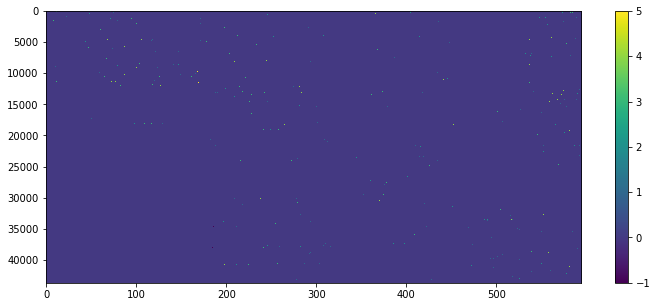

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.imshow(actual_data_test_entry[0, :, :], aspect='auto')
plt.colorbar()
plt.show()
#print(np.sum(actual_data_test_entry[:, :, 0]!=0, axis=0))

In [4]:
# pull options for each column
with open('../data/all_samples_ordinal_cleaned_map.txt', 'r') as f:
    num_options = [int(line.split('\t')[1]) for line in f]

def load_file(filename):
    print('Loading', filename)
    try:
        A = np.load(filename + '.npy')
    except FileNotFoundError:
        #try:
            if 'quad' in filename:
                A = np.loadtxt(filename + '.csv', delimiter=',', dtype=float)

                # need to round responses
                A = np.around(A) 
                for j in range(A.shape[1]):
                    if num_options[j] == 2:
                        A[A[:, j]<=0, j] = -1
                        A[A[:, j]>0, j] = 1
                    else:
                        A[A[:, j] < 1, j] = 1
                        A[A[:, j] > num_options[j], j] = num_options[j]
                A = A.astype(int)
            else:
                converters = dict([(i, lambda s: 1 if s=='true' else -1) for i, num in enumerate(num_options) if num==2])
                A = np.loadtxt(filename + '.csv', delimiter=',', converters = converters, dtype=int)
            np.save(filename, A)
        #except:
        #    print('Not found')
        #    return None
    return A

# Load predictions
ks = [1, 3, 5, 10, 15, 20, 25]
models = ['median'] + \
['quad_cv_k%d' % k for k in ks] + \
['ordhing_cv_k%d' % k for k in ks] + \
['bvs_cv_k%d' % k for k in ks] + \
['mult_cv_k%d' % k for k in ks] + \
['ova_cv_k%d' % k for k in ks]

predictions = np.zeros((len(models), num_folds, m, n))
for i, model in enumerate(models):
    for fold in range(num_folds):
        if model == 'median':
            # baseline median imputation
            train_data = actual_data_train[fold, :, :]
            for col_i in range(n):
                a = train_data[:, col_i]
                a = a[a!=0]
                if a.shape[0] != 0:
                    predictions[i, fold, :, col_i] = int(np.median(a))
        else:
            A = load_file('../models/impute_%s_fold%s' % (model, fold))
            predictions[i, fold, :, :] = A


Loading ../models/impute_quad_cv_k1_fold0
Loading ../models/impute_quad_cv_k1_fold1
Loading ../models/impute_quad_cv_k1_fold2
Loading ../models/impute_quad_cv_k1_fold3
Loading ../models/impute_quad_cv_k1_fold4
Loading ../models/impute_quad_cv_k3_fold0
Loading ../models/impute_quad_cv_k3_fold1
Loading ../models/impute_quad_cv_k3_fold2
Loading ../models/impute_quad_cv_k3_fold3
Loading ../models/impute_quad_cv_k3_fold4
Loading ../models/impute_quad_cv_k5_fold0
Loading ../models/impute_quad_cv_k5_fold1
Loading ../models/impute_quad_cv_k5_fold2
Loading ../models/impute_quad_cv_k5_fold3
Loading ../models/impute_quad_cv_k5_fold4
Loading ../models/impute_quad_cv_k10_fold0
Loading ../models/impute_quad_cv_k10_fold1
Loading ../models/impute_quad_cv_k10_fold2
Loading ../models/impute_quad_cv_k10_fold3
Loading ../models/impute_quad_cv_k10_fold4
Loading ../models/impute_quad_cv_k15_fold0
Loading ../models/impute_quad_cv_k15_fold1
Loading ../models/impute_quad_cv_k15_fold2
Loading ../models/impute_q

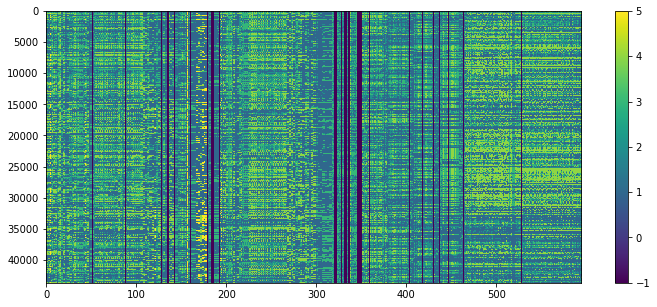

In [5]:
plt.figure(figsize=(12, 5))
#plt.imshow(predictions[models.index('median'), 0, :, :], aspect='auto')
plt.imshow(predictions[20, 1, :, :], aspect='auto')
plt.colorbar()
plt.show()


## Compute metrics

In [6]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

# x=true_values, y=predicted_values
def how_wrong(x, y):
    wrong_indices = np.where(x != y)[0]
    return 0 if wrong_indices.shape[0] == 0 else np.linalg.norm(x[wrong_indices]-y[wrong_indices], 1)/wrong_indices.shape[0]

metrics = {
            #'rmse': lambda x, y: np.sqrt(np.mean((x-y)**2)),
          'accuracy': lambda x, y: accuracy_score(x, y),
          #'kappa': lambda x, y: cohen_kappa_score(x, y),
          #'L1': lambda x, y: np.linalg.norm(x-y, 1)/x.shape[0],
          #'how_wrong': lambda x, y: how_wrong(x, y),
          #'confusion': lambda x, y: confusion_matrix(x, y)
}

In [7]:
# cache nonzero entries for items per fold
nnz_inst, nnz_entry, nnz_train = {}, {}, {}
for fold in range(num_folds):
    inst_true_values = actual_data_test_instrument[fold, :, :]
    entry_true_values = actual_data_test_entry[fold, :, :]
    train_true_values = actual_data_train[fold, :, :]
    
    for item in range(n):
        col = inst_true_values[:, item]
        nnz_inst[(fold, item)] = np.where(col!=0)[0]
        col = entry_true_values[:, item]
        nnz_entry[(fold, item)] = np.where(col!=0)[0]

    nnz_inst[(fold, None)] = np.where(inst_true_values!=0)
    nnz_entry[(fold, None)] = np.where(entry_true_values!=0)
    trainx, trainy = np.where(train_true_values!=0)
    indices = np.random.choice(trainx.shape[0], 5000)
    nnz_train[(fold, None)] = (trainx[indices], trainy[indices])

In [8]:
from collections import defaultdict

def calc_conf(a):
    if len(a) > 1:
        return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    else:
        return None
    
model_metrics = defaultdict(list)
for i, model in enumerate(models):
    print(model)
    for met_key, met_func in metrics.items():
        model_metrics[(model, 'train', met_key)] = []
        model_metrics[(model, 'instrument', met_key)] = []
        model_metrics[(model, 'entry', met_key)] = []
        for item in range(n):
            model_metrics[(model, 'instrument', met_key, item)] = []
            model_metrics[(model, 'entry', met_key, item)] = []
    
        for fold in range(num_folds):
            predicted_values = predictions[i, fold, :, :]
            if not np.isnan(predicted_values[0, 0]):
            
                # train
                train_true_values = actual_data_train[fold, :, :]
                indicesx, indicesy = nnz_train[(fold, None)]
                if indicesx.shape[0] > 0:
                    model_metrics[(model, 'train', met_key)].append(met_func(train_true_values[indicesx, indicesy], predicted_values[indicesx, indicesy]))

                # test-instrument
                inst_true_values = actual_data_test_instrument[fold, :, :]
                indicesx, indicesy = nnz_inst[(fold, None)]
                if indicesx.shape[0] > 0:
                    model_metrics[(model, 'instrument', met_key)].append(met_func(inst_true_values[indicesx, indicesy], predicted_values[indicesx, indicesy]))

                # test-entry
                entry_true_values = actual_data_test_entry[fold, :, :]
                indicesx, indicesy = nnz_entry[(fold, None)]
                if indicesx.shape[0] > 0:
                     model_metrics[(model, 'entry', met_key)].append(met_func(entry_true_values[indicesx, indicesy], predicted_values[indicesx, indicesy]))

                for item in range(n):
                    # item test-instrument
                    indices = nnz_inst[(fold, item)]
                    if indices.shape[0] > 0:
                        model_metrics[(model, 'instrument', met_key, item)].append(met_func(inst_true_values[:, item][indices], predicted_values[:, item][indices]))

                    # item test-entry
                    indices = nnz_entry[(fold, item)]
                    if indices.shape[0] > 0:
                        model_metrics[(model, 'entry', met_key, item)].append(met_func(entry_true_values[:, item][indices], predicted_values[:, item][indices]))
        

median
quad_cv_k1
quad_cv_k3
quad_cv_k5
quad_cv_k10
quad_cv_k15
quad_cv_k20
quad_cv_k25
ordhing_cv_k1
ordhing_cv_k3
ordhing_cv_k5
ordhing_cv_k10
ordhing_cv_k15
ordhing_cv_k20
ordhing_cv_k25
bvs_cv_k1
bvs_cv_k3
bvs_cv_k5
bvs_cv_k10
bvs_cv_k15
bvs_cv_k20
bvs_cv_k25
mult_cv_k1
mult_cv_k3
mult_cv_k5
mult_cv_k10
mult_cv_k15
mult_cv_k20
mult_cv_k25
ova_cv_k1
ova_cv_k3
ova_cv_k5
ova_cv_k10
ova_cv_k15
ova_cv_k20
ova_cv_k25


In [9]:
import scipy.stats as st

ks = [1, 3, 5, 10, 15, 20, 25]

me = 'accuracy'
best_models = [[] for _ in ks]
for i, k in enumerate(ks):
    models_to_consider = ['median', 'quad_cv_k%d' % k, 'ordhing_cv_k%d' % k, 'mult_cv_k%d' % k, 'ova_cv_k%d' % k, 'bvs_cv_k%d' % k, 'multord_cv_k%d' % k]
    for item in range(n):
        data, conf = [], []
        current_model = models_to_consider[0]
        bi, be = model_metrics[(current_model, 'instrument', me, item)], model_metrics[(current_model, 'entry', me, item)]
        for model in models_to_consider[1:]:
            ai, ae = model_metrics[(model, 'instrument', me, item)], model_metrics[(model, 'entry', me, item)]
            cutoff = min(len(ai), len(ae), len(bi), len(be))
            #stat, pvalue = st.ttest_rel(ai[:cutoff]+ae[:cutoff], bi[:cutoff]+be[:cutoff])
            stat, pvalue = st.ttest_rel(ai[:cutoff], bi[:cutoff])

            if stat > 0 and pvalue < 0.1:
                current_model = model
                bi, be = ai, ae
        #print(current_model)
        best_models[i].append(current_model)

#plt.figure(figsize=(15, 5))
#plt.subplot(1, 2, 1)
#plt.boxplot(data)
#plt.xticks(range(1, len(models_to_consider)+1), models_to_consider, rotation='vertical')

#plt.subplot(1, 2, 2)
#plt.fill_between(range(len(models_to_consider)), y1=[x[0] for x in conf], y2=[x[1] for x in conf], alpha=0.1)
#plt.plot([np.mean(x) for x in conf])
#plt.xticks(range(0, len(models_to_consider)), models_to_consider, rotation='vertical')
#plt.show()
        



In [10]:
from collections import Counter

print('k=5', Counter(best_models[0]))
print('k=10', Counter(best_models[1]))
print('k=15', Counter(best_models[2]))
print('k=20', Counter(best_models[3]))
print('k=25', Counter(best_models[4]))

print([i for i, x in enumerate(best_models[0]) if x == 'ordhing_cv_k5'])

k=5 Counter({'median': 490, 'mult_cv_k1': 102, 'quad_cv_k1': 2, 'bvs_cv_k1': 1})
k=10 Counter({'median': 387, 'ova_cv_k3': 102, 'quad_cv_k3': 44, 'mult_cv_k3': 42, 'ordhing_cv_k3': 14, 'bvs_cv_k3': 6})
k=15 Counter({'median': 395, 'mult_cv_k5': 81, 'ova_cv_k5': 43, 'ordhing_cv_k5': 29, 'quad_cv_k5': 26, 'bvs_cv_k5': 21})
k=20 Counter({'median': 431, 'mult_cv_k10': 53, 'ordhing_cv_k10': 38, 'ova_cv_k10': 37, 'quad_cv_k10': 32, 'bvs_cv_k10': 4})
k=25 Counter({'median': 444, 'mult_cv_k15': 53, 'ova_cv_k15': 52, 'ordhing_cv_k15': 21, 'quad_cv_k15': 19, 'bvs_cv_k15': 6})
[]


In [11]:
import scipy.stats as st

# aggregate ks
models_to_consider = ['median', 'quad_cv_k', 'ordhing_cv_k', 'mult_cv_k', 'ova_cv_k', 'bvs_cv_k']
inst_data, entry_data = defaultdict(list), defaultdict(list)

me = 'accuracy'

for i, k in enumerate([5, 10, 15, 20, 25]):
    for item in range(n):
        for model in models_to_consider:
            if model == 'median':
                #inst_data[(model, item)].extend(model_metrics[(model, 'instrument', me, item)])
                #entry_data[(model, item)].extend(model_metrics[(model, 'entry', me, item)])
                inst_data[(model, item)].extend(model_metrics[(model, 'instrument', me, item)])
                entry_data[(model, item)].extend(model_metrics[(model, 'entry', me, item)])
            else:
                inst_data[(model, item)].extend(model_metrics[(model + str(k), 'instrument', me, item)])
                entry_data[(model, item)].extend(model_metrics[(model + str(k), 'entry', me, item)])
                
best_models = []
for item in range(n):
    current_model = models_to_consider[0]
    bi, be = inst_data[(current_model, item)], entry_data[(current_model, item)]
    for model in models_to_consider:
        ai, ae = inst_data[(model, item)], entry_data[(model, item)]
        stat, pvalue = st.ttest_rel(ai+ae, bi+be)

        if stat > 0 and pvalue < 0.1:
            current_model = model
            bi, be = ai, ae
    best_models.append(current_model)

#plt.figure(figsize=(15, 5))
#plt.subplot(1, 2, 1)
#plt.boxplot(data)
#plt.xticks(range(1, len(models_to_consider)+1), models_to_consider, rotation='vertical')

#plt.subplot(1, 2, 2)
#plt.fill_between(range(len(models_to_consider)), y1=[x[0] for x in conf], y2=[x[1] for x in conf], alpha=0.1)
#plt.plot([np.mean(x) for x in conf])
#plt.xticks(range(0, len(models_to_consider)), models_to_consider, rotation='vertical')
#plt.show()
        



In [12]:
print(Counter(best_models))
print([i for i, x in enumerate(best_models) if x == 'quad_cv_k'])

Counter({'median': 299, 'mult_cv_k': 184, 'ova_cv_k': 67, 'quad_cv_k': 32, 'ordhing_cv_k': 7, 'bvs_cv_k': 6})
[29, 41, 57, 79, 86, 150, 154, 322, 323, 325, 330, 337, 338, 363, 366, 376, 381, 384, 404, 411, 425, 437, 439, 448, 449, 450, 457, 467, 475, 495, 522, 525]


median median nan nan
median quad_cv_k 13.716854205067433 7.482399310137631e-13
quad_cv_k ordhing_cv_k -0.8627186901401784 0.39683140388085836
quad_cv_k mult_cv_k 6.4910451904693325 1.0317982674439585e-06
mult_cv_k ova_cv_k -0.3934324129172777 0.6974735167286098
mult_cv_k bvs_cv_k -3.5494279157866044 0.0016300437025567407
mult_cv_k


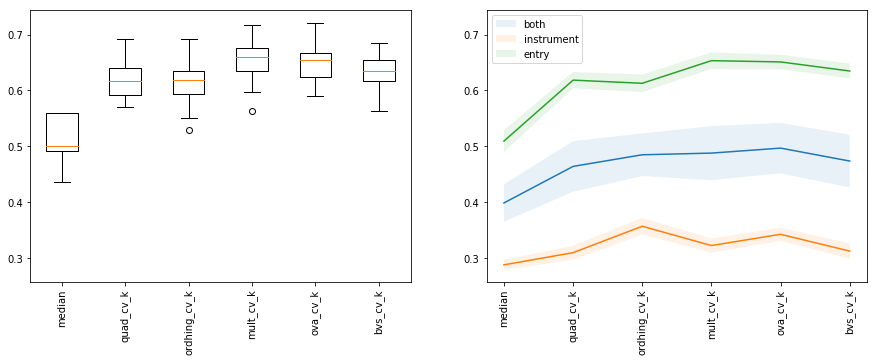

In [13]:
current_model = models_to_consider[0]
bi = entry_data[(current_model, item)]

d, conf, inst_conf, entry_conf = [], [], [], []
for model in models_to_consider:
    ai = entry_data[(model, item)]
    d.append(ai)
    conf.append(calc_conf(inst_data[(model, item)]+entry_data[(model, item)]))
    inst_conf.append(calc_conf(inst_data[(model, item)]))
    entry_conf.append(calc_conf(entry_data[(model, item)]))

    stat, pvalue = st.ttest_rel(ai, bi)
    print(current_model, model, stat, pvalue)
    if stat > 0 and pvalue < 0.1:
        current_model = model
        bi = ai

print(current_model)

plt.figure(figsize=(15, 5))
s1 = plt.subplot(1, 2, 1)
plt.boxplot(d)
plt.xticks(range(1, len(models_to_consider)+1), models_to_consider, rotation='vertical')

plt.subplot(1, 2, 2, sharey=s1)
plt.fill_between(range(len(models_to_consider)), y1=[x[0] for x in conf], y2=[x[1] for x in conf], alpha=0.1, label='both')
plt.plot([np.mean(x) for x in conf])
plt.fill_between(range(len(models_to_consider)), y1=[x[0] for x in inst_conf], y2=[x[1] for x in inst_conf], alpha=0.1, label='instrument')
plt.plot([np.mean(x) for x in inst_conf])
plt.fill_between(range(len(models_to_consider)), y1=[x[0] for x in entry_conf], y2=[x[1] for x in entry_conf], alpha=0.1, label='entry')
plt.plot([np.mean(x) for x in entry_conf])
plt.xticks(range(0, len(models_to_consider)), models_to_consider, rotation='vertical')
plt.legend()

plt.show()
        

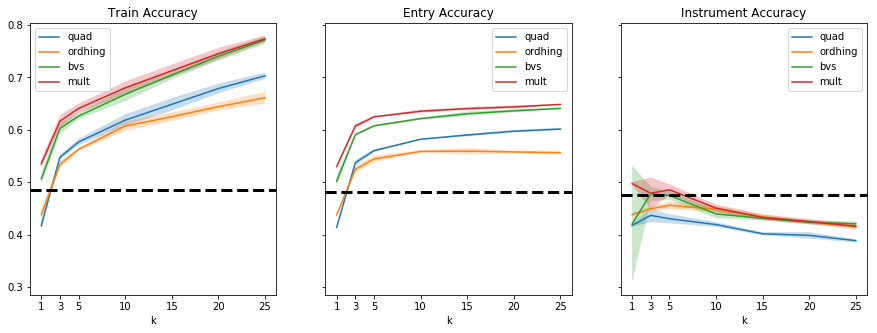

In [24]:
import scipy.stats as st

ks = [1, 3, 5, 10, 15, 20, 25]
me = 'accuracy'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
for model in ['quad', 'ordhing', 'bvs', 'mult']:
    entry_confs, inst_confs, train_confs = [], [], []
    for k in ks:
        entry_confs.append(calc_conf(model_metrics[(model + '_cv_k%d' % k, 'entry', me)]))
        inst_confs.append(calc_conf(model_metrics[(model + '_cv_k%d' % k, 'instrument', me)]))
        train_confs.append(calc_conf(model_metrics[(model + '_cv_k%d' % k, 'train', me)]))
    
    ax1.fill_between(ks, y1=[x[0] for x in train_confs], y2=[x[1] for x in train_confs], alpha=0.25)
    ax1.plot(ks, [np.mean(x) for x in train_confs], label=model)
    ax2.fill_between(ks, y1=[x[0] for x in entry_confs], y2=[x[1] for x in entry_confs], alpha=0.25)
    ax2.plot(ks, [np.mean(x) for x in entry_confs], label=model)
    ax3.fill_between(ks, y1=[x[0] for x in inst_confs], y2=[x[1] for x in inst_confs], alpha=0.25)
    ax3.plot(ks, [np.mean(x) for x in inst_confs], label=model)

ax1.legend()
ax1.set_title('Train Accuracy')
ax1.set_xlabel('k')
ax1.set_xticks(ks)
ax1.axhline(np.mean(model_metrics[('median', 'train', me)]), linestyle='--', linewidth=3, color='black')
ax2.legend()
ax2.set_title('Entry Accuracy')
ax2.set_xlabel('k')
ax2.set_xticks(ks)
ax2.axhline(np.mean(model_metrics[('median', 'entry', me)]), linestyle='--', linewidth=3, color='black')
ax3.legend()
ax3.set_title('Instrument Accuracy')
ax3.set_xlabel('k')
ax3.set_xticks(ks)
ax3.axhline(np.mean(model_metrics[('median', 'instrument', me)]), linestyle='--', linewidth=3, color='black')
plt.show()    

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15, 45))

for j, d in enumerate(datasets):
    if d != 'train':
        for i, k in enumerate(ks):
            fold=0
            true_values = actual_data[j][fold]
            predicted_values = imputed_data[i][fold]
                
            if predicted_values is not None:
                indices = true_values!=0
                true_values = true_values[indices]
                predicted_values = predicted_values[indices]
                    
                plt.subplot(11, 5, j*5+i+1)
                cm = confusion_matrix(true_values, predicted_values)
                plt.imshow(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], vmax=1, vmin=0)
                plt.title('%s-%d' % (d, k))
                classes = np.unique(true_values)
                tick_marks = np.arange(len(classes))
                plt.xticks(tick_marks, classes, rotation=45)
                plt.yticks(tick_marks, classes)
                #print(d, k)
                #print(confusion_matrix(true_values, predicted_values))
plt.tight_layout()
plt.show()

//anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
//anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc
//anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


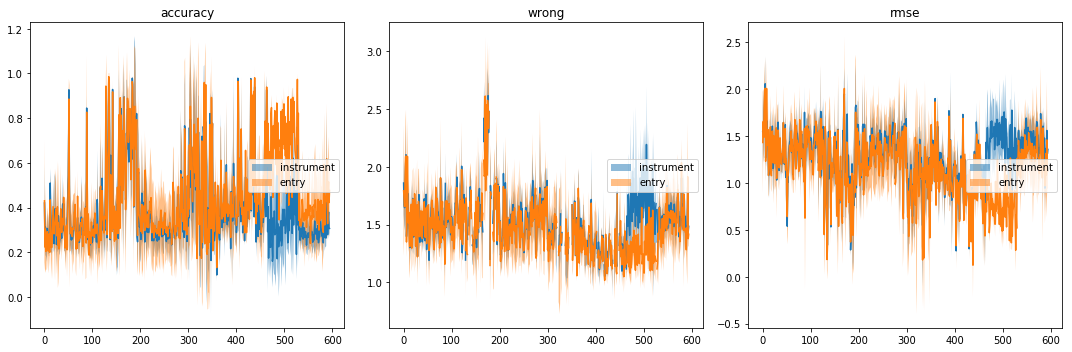

In [49]:
import matplotlib.pyplot as plt
import scipy.stats as st

plt.figure(figsize=(15, 5))

mets = ['accuracy', 'wrong', 'rmse']
k = 10

model = 'mult_scale'
met_ks_inst = [[] for _ in mets]
met_ks_entry = [[] for _ in mets]
n = actual_data[0][0].shape[1]
for item in range(n):
    for j, m in enumerate(mets):
        met_ks_inst[j].append(calc_conf(metrics[(m, model, k, 'instrument', item)]))
        met_ks_entry[j].append(calc_conf(metrics[(m, model, k, 'entry', item)]))

for j in range(3):
    plt.subplot(1, 3, 1+j)
    plt.fill_between(range(n), [x[0] for x in met_ks_inst[j]], y2=[x[1] for x in met_ks_inst[j]], label='instrument', alpha=0.5)
    plt.fill_between(range(n), [x[0] for x in met_ks_entry[j]], y2=[x[1] for x in met_ks_entry[j]], label='entry', alpha=0.5)
    plt.plot([np.mean(x) for x in met_ks_inst[j]])
    plt.plot([np.mean(x) for x in met_ks_entry[j]])

for j, m in enumerate(mets):
    plt.subplot(1, 3, 1+j)
    plt.title('%s' % m)
    #plt.plot(ks, [np.mean(metrics[(m, 'median', d)]) for k in ks], linestyle='--', color='black')
    plt.legend(loc='right')

plt.tight_layout()
plt.show()


//anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


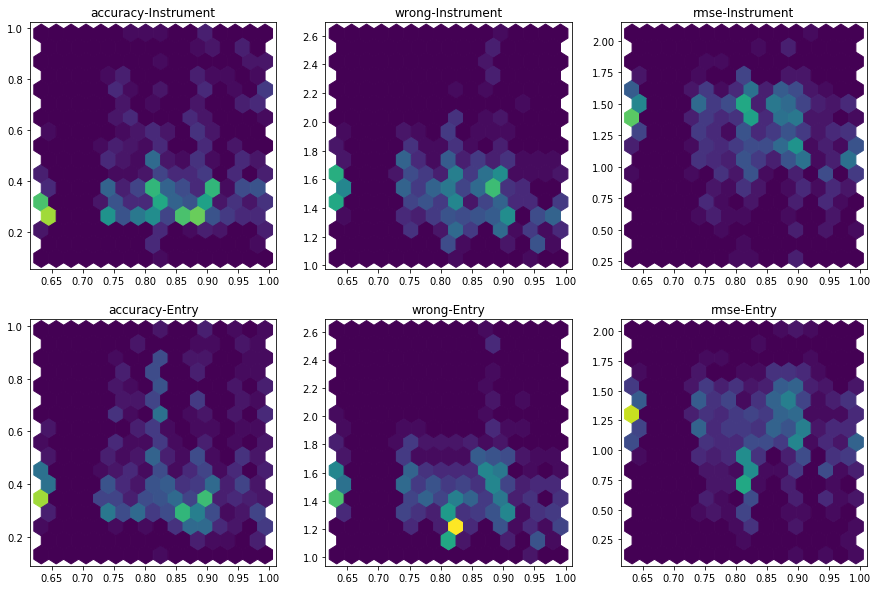

In [51]:
plt.figure(figsize=(15, 10))

num_miss = np.sum(actual_data[0][0]==0, axis=0)/actual_data[0][0].shape[0]

for j in range(3):
    plt.subplot(2, 3, 1+j)
    plt.hexbin(num_miss, [np.mean(x) for x in met_ks_inst[j]], gridsize=15, vmin=0, vmax=35)
    plt.subplot(2, 3, 4+j)
    plt.hexbin(num_miss, [np.mean(x) for x in met_ks_entry[j]], gridsize=15, vmin=0, vmax=35)

for j, m in enumerate(mets):
    plt.subplot(2, 3, 1+j)
    plt.title('%s-Instrument' % m)
    plt.subplot(2, 3, 4+j)
    plt.title('%s-Entry' % m)
    
plt.show()